In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
%matplotlib inline 

from PIL import Image

import struct as st

KeyboardInterrupt: 

# [offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  10000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel

Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black)

The magic number is an integer (MSB first). The first 2 bytes are always 0.

The third byte codes the type of the data: 
0x08: unsigned byte 
0x09: signed byte 
0x0B: short (2 bytes) 
0x0C: int (4 bytes) 
0x0D: float (4 bytes) 
0x0E: double (8 bytes)

In [5]:
### Load the dataset
images_file = open('train-images.idx3-ubyte', 'rb')
images_file.seek(0)
magic_num = st.unpack('>4B', images_file.read(4))
images_size = st.unpack('>I', images_file.read(4))[0]
rows = st.unpack('>I', images_file.read(4))[0]
columns = st.unpack('>I', images_file.read(4))[0]

In [6]:
bytes_to_read = images_size*rows*columns
# (0,255) means white and 255 means black so gotta invert that
images = np.asarray(st.unpack('>' + 'B'*bytes_to_read, images_file.read(bytes_to_read)))
images = np.reshape(images, (images_size, rows, columns))

60000
28
28
47040000
47040000
(60000, 28, 28)


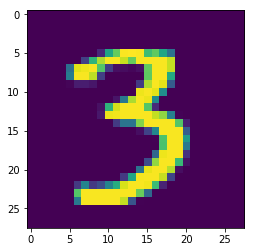

In [7]:
print(images_size)
print(rows)
print(columns)
print(bytes_to_read)
print(images.size)
print(images.shape)
plt.imshow(images[10000], interpolation='none')
plt.show()

# [offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  60000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

In [8]:
### Load the labels
labels_file = open('train-labels.idx1-ubyte', 'rb')
labels_file.seek(0)
magic_num = st.unpack('>4B', labels_file.read(4))
labels_size = st.unpack('>I', labels_file.read(4))[0]

labels = np.asarray(st.unpack('>' + 'B'*labels_size, labels_file.read(labels_size))).reshape((labels_size))

In [9]:
print(labels.size)
print(labels.shape)
print(labels[10000])

60000
(60000,)
3


In [ ]:
## Flatten the images & normalize
image_vectors = np.reshape(images, (images_size, rows*columns)) / 255
print(image_vectors.shape)
print(image_vectors[10000])
## Split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_vectors, labels, test_size=0.3, random_state=42)

In [ ]:
class KMeans:
    def __init__(self, n_clusters = 5, n_restarts = 3, max_iter = 50, epsilon = 0.0001):
        self.n_clusters = n_clusters
        self.n_restarts = n_restarts
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.X_train = None
        self.centroids = None
        self.cluster_assignments = None
        self.statistics = {
            'inertia': np.zeros((self.n_restarts, self.max_iter)),
            'variances': np.zeros((self.n_restarts, self.max_iter, self.n_clusters))
        }
        
    def fit(self, X_train):
        self.X_train = X_train
        self.cluster_assignments = np.zeros(self.X_train.shape[0])
        
        for restart in np.arange(self.n_restarts):
            self.init_centroids()
            for it in np.arange(self.max_iter):
                self.statistics['inertia'][restart, it] = self.assign_clusters()
                self.statistics['inertia'][restart, it, :] = self.compute_centroids()
                ## Add Stopping condition based on epsilon
     
    def init_centroids(self):
        random_indices = np.random.choice(self.X_train.shape[0], self.n_clusters)
        self.centroids = self.X_train[random_indices]
        
    def assign_clusters(self):
        distances = np.zeros((self.X_train.shape[0], self.n_clusters))
        min_distances = np.zeros(self.X_train.shape[0])
        for eg in np.arange(self.X_train.shape[0]):
            distances[eg] = np.linalg.norm(self.X_train[eg]-self.centroids, axis = 1)
            min_distances[eg], self.cluster_assignments[eg] = np.min(distances[eg]), np.argmin(distances[eg])
        return np.sum(min_distances)
    
    def compute_centroids(self):
        variances = np.zeros(self.n_clusters)
        for k in np.arange(self.n_clusters):
            self.centroids[k] = np.mean(self.X_train[self.cluster_assignments==k], axis = 0)
            variances[k] = np.var(self.X_train[self.cluster_assignments==k], axis = 0)
        return variances    
                

In [4]:
def map_labels(true_labels, k_labels):
    mapping = {k: k for k in np.unique(k_labels)}
    
    for k in np.unique(k_labels):
        k_mapping = np.argmax(np.bincount(true_labels[k_labels==k]))
        mapping[k] = k_mapping
            
    predictions = [mapping[label] for label in k_labels]
    
    return mapping, predictions

In [5]:
test_array = np.array([1, 2, 3, 1, 2, 3, 1, 2, 3])
test_k_array = np.array([3, 2, 1, 3, 2, 1, 3, 2, 1])
mapping, predictions = map_labels(test_array, test_k_array)
print(mapping)
print(predictions)

{1: 3, 2: 2, 3: 1}
[1, 2, 3, 1, 2, 3, 1, 2, 3]


In [23]:
### Now to the model
k_values = [5, 10]
train_scores= np.zeros(len(k_values))
test_scores= np.zeros(len(k_values))
k_cluster_centers = []
k_mappings = []
k_predictions = []
for k in k_values:
    kmeans = KMeans(n_clusters = k, init='random', n_init = 5).fit(X_train)
    ## rearrange labels to vote for majority it points to
    train_mapping , train_predictions = map_labels(y_train, kmeans.labels_)
    train_scores[k_values.index(k)] = accuracy_score(y_train, train_predictions)
    
    test_labels = kmeans.predict(X_test)
    test_predictions = [train_mapping[label] for label in test_labels]
    test_scores[k_values.index(k)] = accuracy_score(y_test, test_predictions)
    
    k_cluster_centers.append(kmeans.cluster_centers_)
    k_mappings.append(train_mapping)
    k_predictions.append(train_predictions)        

In [ ]:
dummy_train = np.arange(1600).reshape((20, 80))
kmeans = KMeans(n_clusters = 4, verbose = 1).fit(dummy_train)

For k =  5:
Train Accuracy = 0.4509, Test Accuracy = 0.4537
Mean Images of cluster:

Mean:cluster 0 maps to label 0


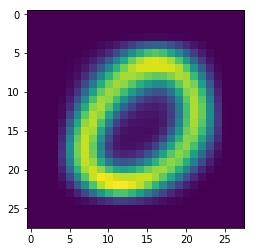

Sample:cluster 0 maps to label 0


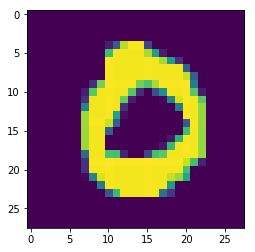

Mean:cluster 1 maps to label 1


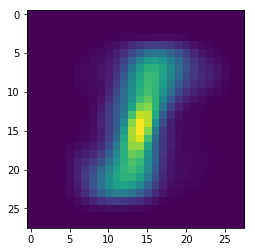

Sample:cluster 1 maps to label 1


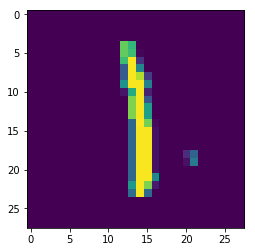

Mean:cluster 2 maps to label 3


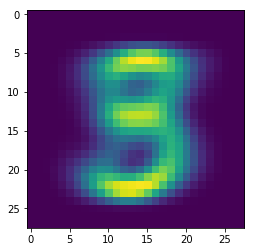

Sample:cluster 2 maps to label 3


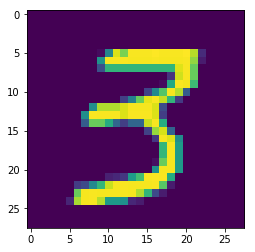

Mean:cluster 3 maps to label 7


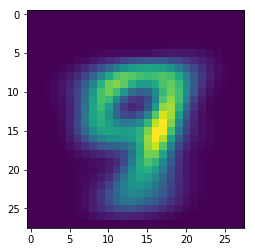

Sample:cluster 3 maps to label 7


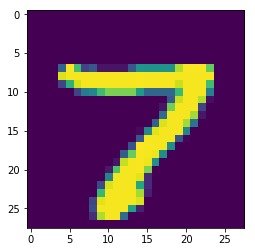

Mean:cluster 4 maps to label 6


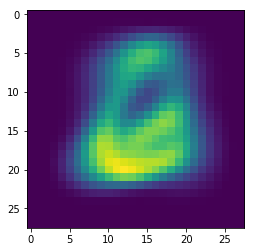

Sample:cluster 4 maps to label 6


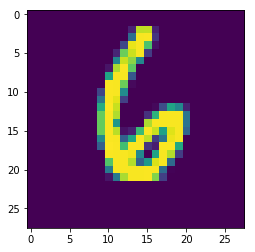

For k = 10:
Train Accuracy = 0.5796, Test Accuracy = 0.5722
Mean Images of cluster:

Mean:cluster 0 maps to label 4


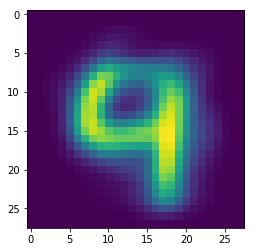

Sample:cluster 0 maps to label 4


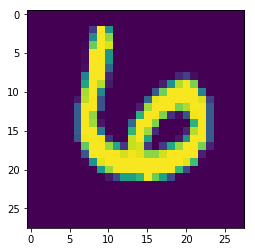

Mean:cluster 1 maps to label 1


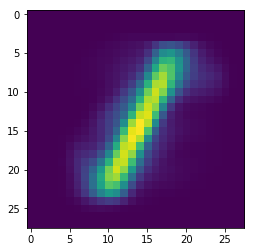

Sample:cluster 1 maps to label 1


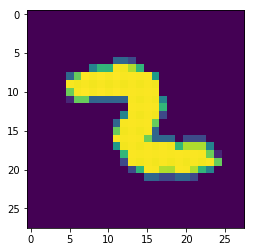

Mean:cluster 2 maps to label 3


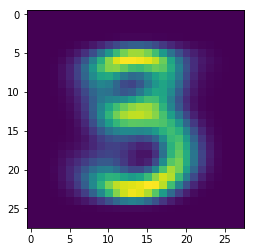

Sample:cluster 2 maps to label 3


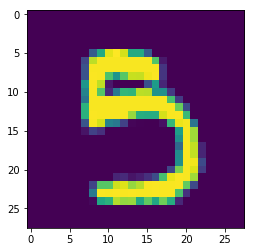

Mean:cluster 3 maps to label 8


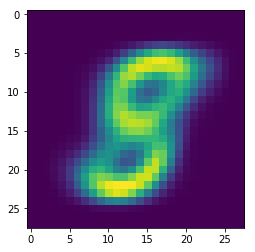

Sample:cluster 3 maps to label 8


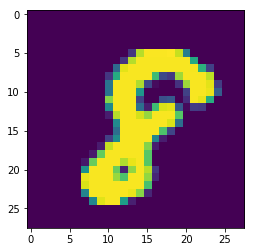

Mean:cluster 4 maps to label 0


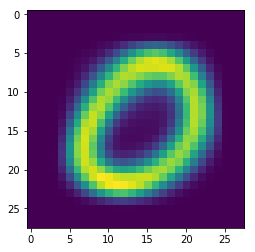

Sample:cluster 4 maps to label 0


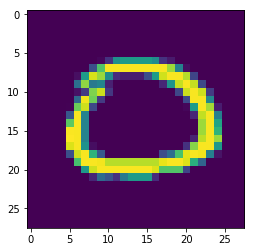

Mean:cluster 5 maps to label 7


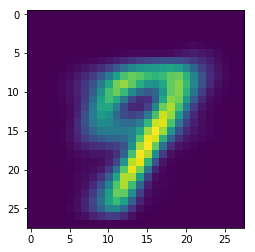

Sample:cluster 5 maps to label 7


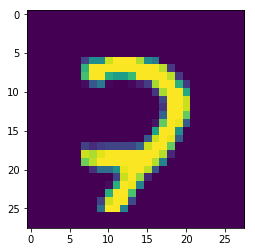

Mean:cluster 6 maps to label 6


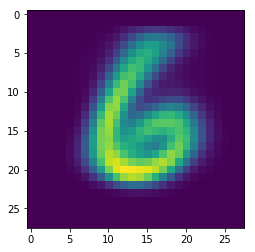

Sample:cluster 6 maps to label 6


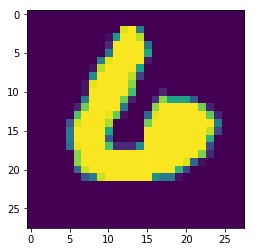

Mean:cluster 7 maps to label 2


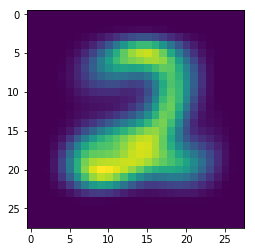

Sample:cluster 7 maps to label 2


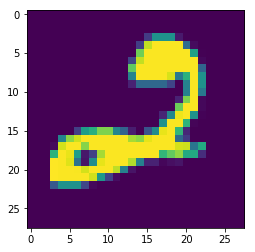

Mean:cluster 8 maps to label 1


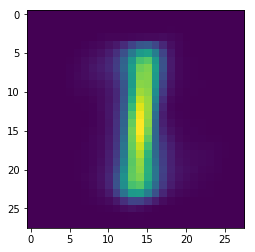

Sample:cluster 8 maps to label 1


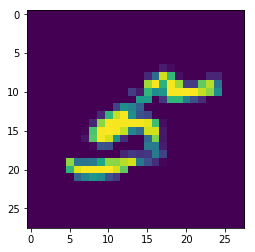

Mean:cluster 9 maps to label 9


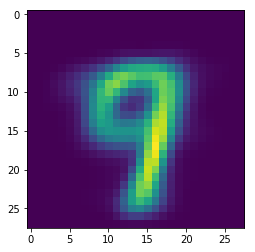

Sample:cluster 9 maps to label 9


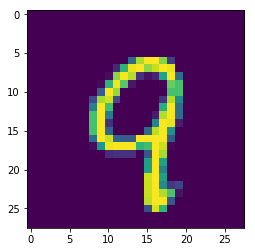

In [28]:
for k in k_values:
    train_score = train_scores[k_values.index(k)]
    test_score = test_scores[k_values.index(k)]
    cluster_centers = k_cluster_centers[k_values.index(k)]
    mapping = k_mappings[k_values.index(k)]
    predictions = k_predictions[k_values.index(k)]
    print("For k = %2d:\nTrain Accuracy = %1.4f, Test Accuracy = %1.4f" % (k, train_score, test_score))
    print('Mean Images of cluster:\n')
    for k_ in np.arange(k):
        cluster_center = cluster_centers[k_]
        mean_image = np.reshape(cluster_center, (rows, columns))
        print("Mean:cluster %d maps to label %d" % (k_, mapping[k_]))
        plt.imshow(mean_image, interpolation='none')
        plt.show()
        sample_vectors= X_train[predictions==mapping[k_], :]
        sample_vector = sample_vectors[np.random.randint(sample_vectors.shape[0], size=1), :]
        sample_image = np.reshape(sample_vector, (rows, columns))
        print("Sample:cluster %d maps to label %d" % (k_, mapping[k_]))
        plt.imshow(sample_image, interpolation='none')
        plt.show()

In [3]:
a = 5
b = 2
c = 3
image_filename = 'K'+ str(a) + '_c' + str(b) + '_map' + str(c) + '.png'
print(image_filename)
image_array = np.arange(256).reshape(16, 16)
img = Image.fromarray(image_array)
img.save('img.png')
img.show()

K5_c2_map3.png


In [19]:
for k in k_values:
    train_score = train_scores[k_values.index(k)]
    test_score = test_scores[k_values.index(k)]
    cluster_centers = k_cluster_centers[k_values.index(k)]
    mapping = k_mappings[k_values.index(k)]
    predictions = k_predictions[k_values.index(k)]
    for k_ in np.arange(k):
        cluster_center = cluster_centers[k_]
        mean_image_array = np.reshape(cluster_center, (rows, columns))
        mean_image_filename = 'K'+ str(k) + '_c' + str(k_) + '_map' + str(mapping[k_]) + '_mean' + '.png'
        img = Image.fromarray(mean_image_array).convert('RGB')
        img.save(mean_image_filename)
        
        sample_vectors= X_train[predictions==mapping[k_], :]
        sample_vector = sample_vectors[np.random.randint(sample_vectors.shape[0], size=1), :]
        sample_image_array = np.reshape(sample_vector, (rows, columns))
        sample_image_filename = 'K'+ str(k) + '_c' + str(k_) + '_map' + str(mapping[k_]) + '_sample' + '.png'
        img = Image.fromarray(sample_image_array).convert('RGB')
        img.save(sample_image_filename)